In [1]:
# 1/24/2022
# markstro
#
# This notebook demos: (1) how to read the CBH file and adjust the values for the HRUS; (2) determine the
# form of the precip' (3) read values from the parameter file and use them in calculations.

In [2]:
import pandas as pd
import numpy as np
import gc
import sys
import os
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
import math


In [3]:
pfn = "C:/Users/markstro/jupyter_notebooks/EC/hru1/input/hru1.params"
outdir = "C:/Users/markstro/jupyter_notebooks/EC/hru1/output/"
indir = "C:/Users/markstro/jupyter_notebooks/EC/hru1/input/"

# Utility functions

In [4]:
# Function that will read PRMS parameter file
# Returns the contents of param file in python data structures
def read_param_file(pfn):
    line_num = 0
    vals = {}
    dims = {}
    param_dims = {}
    param_type = {}

    with open(pfn) as f:
        reading_dims = False
        for line in f:
            try:
                line = line.rstrip()  # remove '\n' at end of line
                line_num += 1
                if line == '** Dimensions **':
                    reading_dims = True
                    line = f.readline().rstrip() 
                    line_num += 1

                if line == '** Parameters **':
                    reading_dims = False
                    break

                if reading_dims:
                    line = f.readline().rstrip()
                    line_num += 1
                    dim_name = line
                    
                    line = f.readline().rstrip() 
                    line_num += 1
                    size = line
                    
                    if dim_name in dims.keys():
                        pass
                    else:
                        dims[dim_name] = int(size)
            except:
                print("**** read parameters exception line = ", line)
                print("**** read parameters exception line_num = ", str(line_num))
                print("**** Unexpected error:", sys.exc_info()[0])

#        read params
        for line in f:
            try:
                line = line.rstrip()  # remove '\n' at end of line
                line_num += 1

                if line == "####":
                    line = f.readline().rstrip()
                    line = line.split(' ', 1)[0]  # old format parameter files have a blank (' ') and then a width format value. Strip this off.
                    param_name = line
                    line_num += 1

                    line = f.readline().rstrip()
                    line_num += 1
                    num_dims = int(line)
                    pd = [None] * num_dims
                    for ii in range(num_dims):
                        line = f.readline().rstrip()
                        pd[ii] = line
                        line_num += 1

                    param_dims[param_name] = pd

                    line = f.readline().rstrip()
                    line_num += 1
                    num_vals = int(line)
                    line = f.readline().rstrip()
                    line_num += 1
                    tp = int(line)
                    param_type[param_name] = tp

                    if tp == 2:
                        vs = np.zeros(num_vals, dtype=np.float)
                        for jj in range(num_vals):
                            line = f.readline().rstrip()
                            line_num += 1
                            vs[jj] = float(line)

                    elif tp == 1:
                        vs = np.zeros(num_vals, dtype=np.int)
                        for jj in range(num_vals):
                            line = f.readline().rstrip()
                            line_num += 1
                            vs[jj] = int(line)

                    else:
                        vs = np.zeros(num_vals, dtype=np.chararray)
                        for jj in range(num_vals):
                            line = f.readline().rstrip()
                            line_num += 1
                            vs[jj] = line

                    if num_dims == 2:
                        vs.shape = (dims[pd[1]], dims[pd[0]])

                    if param_name in vals.keys():
                        print("parameter ", param_name, " is already in ", pfn)
                    else:
                        vals[param_name] = vs

            except:
                print("read parameters exception line_num = ", str(line_num))
                print("Unexpected error:", sys.exc_info()[0])
                
    gc.collect()
    
    return (dims, vals, param_dims, param_type)

In [5]:
# I don't understand why I needed to write this function myself
# Input: datetime.Date
# Output: day of the year (aka "Julian date")
def day_of_year(d):
    N1 = math.floor(275 * d.month / 9)
    N2 = math.floor((d.month + 9) / 12)
    N3 = (1 + math.floor((d.year - 4 * math.floor(d.year / 4) + 2) / 3))
    N = N1 - (N2 * N3) + d.day - 30
    return N

# Read the simulated output into a dataframe

In [6]:
# This loops over all of the csv files in the output directory

sim_vals = None
for filename in os.listdir(outdir):
    f = os.path.join(outdir,filename)
    if os.path.isfile(f) and f.endswith('.csv'):
        varname = filename.split('.')[0]
        
        if sim_vals is None:
            sim_vals = pd.read_csv(f, names=["datestr", varname], skiprows=1)
            
        else:
            if varname != 'stats':
                df = pd.read_csv(f, names=["datestr", varname], skiprows=1)
                sim_vals = pd.merge(sim_vals, df[["datestr", varname]], on="datestr", how="left")

sim_vals["date"] = [datetime.strptime(date, '%Y-%m-%d').date() for date in sim_vals["datestr"]]
del sim_vals['datestr']

In [7]:
sim_vals.head()

,basin_horad,basin_orad,canopy_covden,hru_ppt,hru_rain,hru_snow,intcp_evap,intcp_stor,net_ppt,net_rain,...,pkwater_equiv,potet,pptmix,soil_moist_tot,swrad,tmaxf,tminc,tminf,transp_on,date
0,637.1866,401.4003,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,...,0.0,0.1863,0,0.0000,403.8735,78.5987,9.8522,49.7339,1,1980-10-01
1,631.0960,393.9506,0.2308,0.1039,0.1039,0.0,0.0000,0.0038,0.1030,0.1030,...,0.0,0.1840,0,0.0566,396.4248,77.5987,10.8522,51.5339,1,1980-10-02
2,625.0040,317.8949,0.2308,0.2629,0.2629,0.0,0.0000,0.0038,0.2629,0.2629,...,0.0,0.1359,0,0.2017,319.9297,66.2987,10.6300,51.1339,1,1980-10-03
3,618.9124,314.7966,0.2308,0.0672,0.0672,0.0,0.0000,0.0038,0.0672,0.0672,...,0.0,0.1282,0,0.2280,316.8498,66.2987,7.2411,45.0339,1,1980-10-04
4,612.8231,278.0202,0.2308,0.0000,0.0000,0.0,0.0038,0.0000,0.0000,0.0000,...,0.0,0.1083,0,0.2147,279.8678,63.0987,6.0744,42.9339,1,1980-10-05


In [8]:
sim_vals.tail()

,basin_horad,basin_orad,canopy_covden,hru_ppt,hru_rain,hru_snow,intcp_evap,intcp_stor,net_ppt,net_rain,...,pkwater_equiv,potet,pptmix,soil_moist_tot,swrad,tmaxf,tminc,tminf,transp_on,date
360,673.5969,144.6075,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0559,0,0.6204,145.3992,66.1987,10.4633,50.8339,1,1981-09-26
361,667.5533,358.0934,0.2308,0.0122,0.0122,0.0,0.0000,0.0038,0.0113,0.0113,...,0.0,0.1527,0,0.5382,360.0937,77.4987,11.4633,52.6339,1,1981-09-27
362,661.4974,232.0970,0.2308,0.0000,0.0000,0.0,0.0038,0.0000,0.0000,0.0000,...,0.0,0.0864,0,0.5142,233.4196,69.1987,6.2411,43.2339,1,1981-09-28
363,655.4311,131.0862,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0437,0,0.5026,131.8481,59.0987,4.6855,40.4339,1,1981-09-29
364,649.3560,129.8712,0.2308,0.0122,0.0122,0.0,0.0000,0.0038,0.0113,0.0113,...,0.0,0.0438,0,0.4990,130.6410,61.7987,3.8522,38.9339,1,1981-09-30


# Read the CBH forcing data into the dataframe

In [9]:
def add_date_for_PRMS_dates(df):
    df["date"] = [date(y, m, d) for y, m, d in zip(df["yr"], df["mo"], df["da"])]
    del df["yr"]
    del df["mo"]
    del df["da"]
    del df["hr"]
    del df["mi"]
    del df["se"]
    return df

In [10]:
# Read the CBH forcing inputs
cbh_vals = None
for filename in os.listdir(indir):
    f = os.path.join(indir,filename)
    if os.path.isfile(f) and f.endswith('.cbh'):
        varname = filename.split('.')[0]
        
        if cbh_vals is None:
            cbh_vals = pd.read_csv(f, names=["yr", "mo", "da", "hr", "mi", "se", varname], skiprows=3, delim_whitespace=True)
            cbh_vals = add_date_for_PRMS_dates(cbh_vals)

        else:
            foo = pd.read_csv(f, names=["yr", "mo", "da", "hr", "mi", "se", varname], skiprows=3, delim_whitespace=True)
            foo = add_date_for_PRMS_dates(foo)
            cbh_vals = pd.merge(cbh_vals, foo[["date", varname]], on="date", how="left")

In [11]:
cbh_vals.head()

,prcp,date,tmax,tmin
0,0.00,1979-01-01,43.6,31.0
1,0.04,1979-01-02,47.2,31.0
2,0.02,1979-01-03,53.0,34.1
3,0.49,1979-01-04,53.7,38.2
4,0.48,1979-01-05,42.9,34.9


In [12]:
cbh_vals.tail()

,prcp,date,tmax,tmin
14977,0.00,2019-12-27,50.6,34.2
14978,0.00,2019-12-28,48.3,29.1
14979,0.76,2019-12-29,41.8,29.6
14980,0.82,2019-12-30,39.6,34.6
14981,0.11,2019-12-31,43.8,35.3


# Sync up the dates of the forcings and the outputs. This makes sure that all values are compared for the same date(s)

In [13]:
synced_vals = pd.merge(cbh_vals, sim_vals, on="date", how="right")

In [14]:
print(synced_vals.shape)

(365, 26)


In [15]:
synced_vals.head()

,prcp,date,tmax,tmin,basin_horad,basin_orad,canopy_covden,hru_ppt,hru_rain,hru_snow,...,orad,pkwater_equiv,potet,pptmix,soil_moist_tot,swrad,tmaxf,tminc,tminf,transp_on
0,0.00,1980-10-01,77.5,50.1,637.1866,401.4003,0.2308,0.0000,0.0000,0.0,...,401.4003,0.0,0.1863,0,0.0000,403.8735,78.5987,9.8522,49.7339,1
1,0.17,1980-10-02,76.5,51.9,631.0960,393.9506,0.2308,0.1039,0.1039,0.0,...,393.9506,0.0,0.1840,0,0.0566,396.4248,77.5987,10.8522,51.5339,1
2,0.43,1980-10-03,65.2,51.5,625.0040,317.8949,0.2308,0.2629,0.2629,0.0,...,317.8949,0.0,0.1359,0,0.2017,319.9297,66.2987,10.6300,51.1339,1
3,0.11,1980-10-04,65.2,45.4,618.9124,314.7966,0.2308,0.0672,0.0672,0.0,...,314.7966,0.0,0.1282,0,0.2280,316.8498,66.2987,7.2411,45.0339,1
4,0.00,1980-10-05,62.0,43.3,612.8231,278.0202,0.2308,0.0000,0.0000,0.0,...,278.0202,0.0,0.1083,0,0.2147,279.8678,63.0987,6.0744,42.9339,1


In [16]:
synced_vals.tail()

,prcp,date,tmax,tmin,basin_horad,basin_orad,canopy_covden,hru_ppt,hru_rain,hru_snow,...,orad,pkwater_equiv,potet,pptmix,soil_moist_tot,swrad,tmaxf,tminc,tminf,transp_on
360,0.00,1981-09-26,65.1,51.2,673.5969,144.6075,0.2308,0.0000,0.0000,0.0,...,144.6075,0.0,0.0559,0,0.6204,145.3992,66.1987,10.4633,50.8339,1
361,0.02,1981-09-27,76.4,53.0,667.5533,358.0934,0.2308,0.0122,0.0122,0.0,...,358.0934,0.0,0.1527,0,0.5382,360.0937,77.4987,11.4633,52.6339,1
362,0.00,1981-09-28,68.1,43.6,661.4974,232.0970,0.2308,0.0000,0.0000,0.0,...,232.0970,0.0,0.0864,0,0.5142,233.4196,69.1987,6.2411,43.2339,1
363,0.00,1981-09-29,58.0,40.8,655.4311,131.0862,0.2308,0.0000,0.0000,0.0,...,131.0862,0.0,0.0437,0,0.5026,131.8481,59.0987,4.6855,40.4339,1
364,0.02,1981-09-30,60.7,39.3,649.3560,129.8712,0.2308,0.0122,0.0122,0.0,...,129.8712,0.0,0.0438,0,0.4990,130.6410,61.7987,3.8522,38.9339,1


In [17]:
synced_vals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   prcp            365 non-null    float64
 1   date            365 non-null    object 
 2   tmax            365 non-null    float64
 3   tmin            365 non-null    float64
 4   basin_horad     365 non-null    float64
 5   basin_orad      365 non-null    float64
 6   canopy_covden   365 non-null    float64
 7   hru_ppt         365 non-null    float64
 8   hru_rain        365 non-null    float64
 9   hru_snow        365 non-null    float64
 10  intcp_evap      365 non-null    float64
 11  intcp_stor      365 non-null    float64
 12  net_ppt         365 non-null    float64
 13  net_rain        365 non-null    float64
 14  net_snow        365 non-null    float64
 15  newsnow         365 non-null    int64  
 16  orad            365 non-null    float64
 17  pkwater_equiv   365 non-null    flo

# Compute the adjusted hru temperatures

In [18]:
# Compute the adjusted HRU temperature

def adjust_temp(dates, tmx, tmn, tmxadj, tmnadj):
    tmx_hru = np.zeros(len(dates))
    tmn_hru = np.zeros(len(dates))

    ii = 0
    for date in dates:
        jday = day_of_year(date)
        imon = date.month - 1
        tmx_hru[ii] = tmx[ii] + tmxadj[imon]
        tmn_hru[ii] = tmn[ii] + tmnadj[imon]
        ii += 1
        
    return tmn_hru, tmx_hru

In [19]:
# call adjust_temp

dates = synced_vals["date"].values
tmax = synced_vals["tmax"].values
tmin = synced_vals["tmin"].values

params = read_param_file(pfn)
vals = params[1]
tmax_cbh_adj = vals["tmax_cbh_adj"]
tmin_cbh_adj = vals["tmin_cbh_adj"]

tmin_hru, tmax_hru = adjust_temp(dates, tmax, tmin, tmax_cbh_adj, tmin_cbh_adj)

In [20]:
err = synced_vals["tmaxf"].values - tmax_hru
print(sum(synced_vals["tmaxf"].values), sum(tmax_hru))

21555.099799999996 21555.102405299996


Text(0, 0.5, 'Error tmax_hru (Degrees F)')

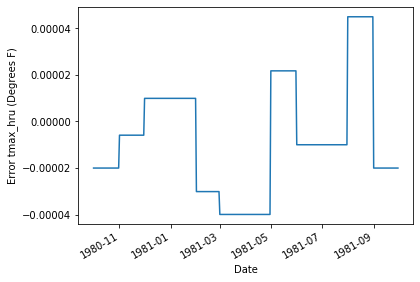

In [21]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Date")
plt.ylabel("Error tmax_hru (Degrees F)")

Text(0, 0.5, 'Python computed tmax_hru (Degrees F)')

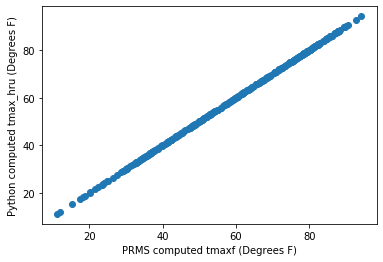

In [22]:
plt.scatter(synced_vals["tmaxf"].values, tmax_hru)
plt.xlabel("PRMS computed tmaxf (Degrees F)")
plt.ylabel("Python computed tmax_hru (Degrees F)")

In [23]:
err = synced_vals["tminf"].values - tmin_hru
print(sum(synced_vals["tminf"].values), sum(tmin_hru))

14900.501299999996 14900.497526599996


Text(0, 0.5, 'Error tmin_hru (Degrees F)')

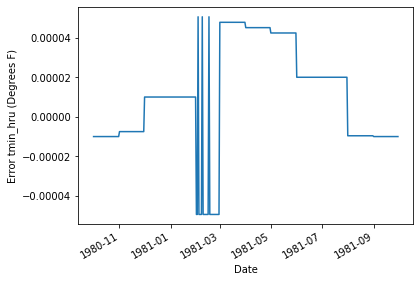

In [24]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Date")
plt.ylabel("Error tmin_hru (Degrees F)")

Text(0, 0.5, 'Python computed tmin_hru (Degrees F)')

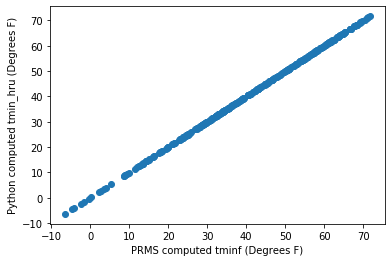

In [25]:
plt.scatter(synced_vals["tminf"].values, tmin_hru)
plt.xlabel("PRMS computed tminf (Degrees F)")
plt.ylabel("Python computed tmin_hru (Degrees F)")

# Compute the precip form and the adjusted precip

In [26]:
def adjust_precip(dates, ppt, tmnh, tmxh, tmax_allsnow, tmax_allrain, snow_cbh_adj,
                  rain_cbh_adj, adjmix_rain):
    hru_ppt = np.zeros(len(dates))
    hru_snow = np.zeros(len(dates))
    hru_rain = np.zeros(len(dates))
    newsnow = np.zeros(len(dates), dtype=int)
    pptmix = np.zeros(len(dates), dtype=int)

    ii = 0
    for date in dates:
        jday = day_of_year(date)
        imon = date.month - 1

        if ppt[ii] > 0.0:
            if tmxh[ii] <= tmax_allsnow[imon]:
                hru_ppt[ii] = ppt[ii] * snow_cbh_adj[imon]
                hru_snow[ii] = hru_ppt[ii]
                prmx = 0.0
                newsnow[ii] = True

            elif (tmnh[ii] > tmax_allsnow[imon]) or (tmxh[ii] >= tmax_allrain[imon]):
                hru_ppt[ii] = ppt[ii] * rain_cbh_adj[imon]
                hru_rain[ii] = hru_ppt[ii]
                prmx = 1.0

            else:
                tdiff = tmxh[ii] - tmnh[ii]
                prmx = ((tmxh[ii] - tmax_allsnow[imon]) / (tmxh[ii] - tmnh[ii])) * adjmix_rain[imon]

                if prmx < 1.0:
                    pptmix[ii] = True
                    hru_ppt[ii] = ppt[ii] * snow_cbh_adj[imon]
                    hru_rain[ii] = prmx * hru_ppt[ii]
                    hru_snow[ii] = hru_ppt[ii] - hru_rain[ii]
                    newsnow[ii] = True
                else:
                    hru_ppt[ii] = ppt[ii] * rain_cbh_adj[imon]
                    hru_rain[ii] = hru_ppt[ii]
        ii += 1
        
    return hru_ppt, hru_snow, hru_rain, newsnow, pptmix

In [27]:
# call adjust_precip

dates = synced_vals["date"].values
prcp = synced_vals["prcp"].values

params = read_param_file(pfn)
vals = params[1]
tmax_allsnow = vals["tmax_allsnow"]
tmax_allrain_offset = vals["tmax_allrain_offset"]
tmax_allrain = tmax_allsnow + tmax_allrain_offset
snow_cbh_adj = vals["snow_cbh_adj"]
rain_cbh_adj = vals["rain_cbh_adj"]
adjmix_rain = vals["adjmix_rain"]

# tmin_hru and tmax_hru come from the call to adjust_temp
hru_ppt, hru_snow, hru_rain, newsnow, pptmix = adjust_precip(dates, prcp, tmin_hru, tmax_hru, tmax_allsnow,
                                            tmax_allrain, snow_cbh_adj, rain_cbh_adj,
                                            adjmix_rain)

In [28]:
err = synced_vals["hru_ppt"].values - hru_ppt
print(sum(synced_vals["hru_ppt"].values), sum(hru_ppt))

41.0725 41.072602573000026


Text(0, 0.5, 'Error hru_ppt (Inches per day)')

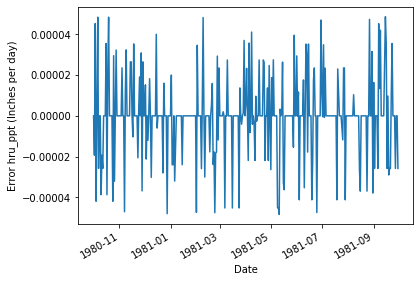

In [29]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Date")
plt.ylabel("Error hru_ppt (Inches per day)")

Text(0, 0.5, 'Python computed hru_ppt (Inches per day)')

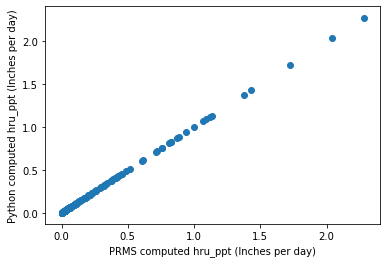

In [30]:
plt.scatter(synced_vals["hru_ppt"].values, hru_ppt)
plt.xlabel("PRMS computed hru_ppt (Inches per day)")
plt.ylabel("Python computed hru_ppt (Inches per day)")

In [31]:
err = synced_vals["hru_rain"].values - hru_rain

Text(0, 0.5, 'Error hru_rain (Inches per day)')

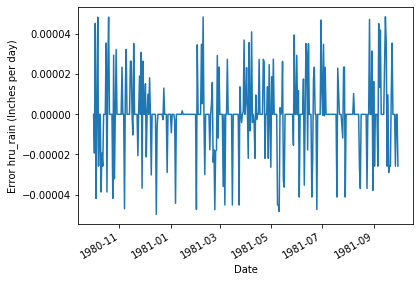

In [32]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Date")
plt.ylabel("Error hru_rain (Inches per day)")

Text(0, 0.5, 'Python computed hru_rain (Inches per day)')

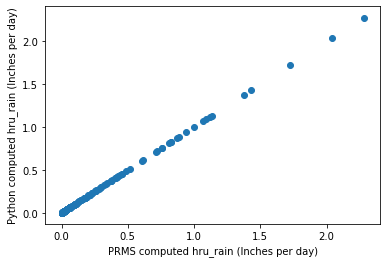

In [33]:
plt.scatter(synced_vals["hru_rain"].values, hru_rain)
plt.xlabel("PRMS computed hru_rain (Inches per day)")
plt.ylabel("Python computed hru_rain (Inches per day)")

In [34]:
err = synced_vals["hru_snow"].values - hru_snow

Text(0, 0.5, 'Error hru_snow (Inches per day)')

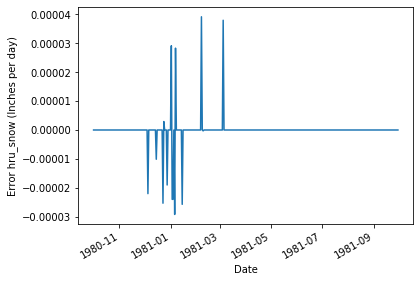

In [35]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Date")
plt.ylabel("Error hru_snow (Inches per day)")

Text(0, 0.5, 'Python computed hru_snow (Inches per day)')

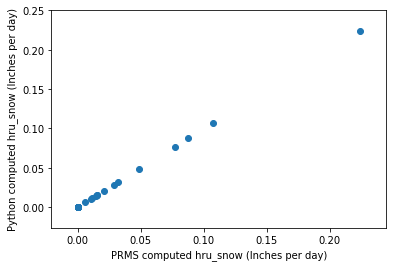

In [36]:
plt.scatter(synced_vals["hru_snow"].values, hru_snow)
plt.xlabel("PRMS computed hru_snow (Inches per day)")
plt.ylabel("Python computed hru_snow (Inches per day)")

Text(0, 0.5, 'newsnow (Unitless)')

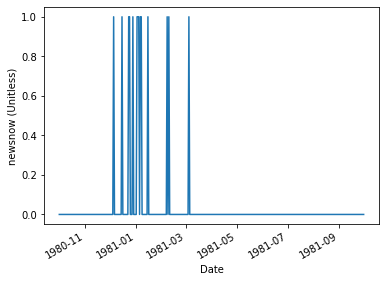

In [37]:
plt.plot(dates, newsnow)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Date")
plt.ylabel("newsnow (Unitless)")

Text(0, 0.5, 'newsnow (Unitless)')

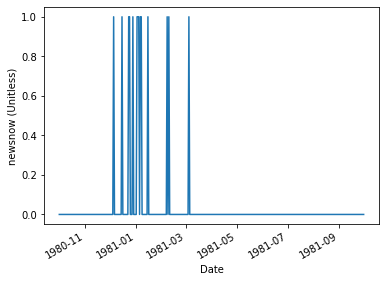

In [38]:
plt.plot(dates, synced_vals["newsnow"].values)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Date")
plt.ylabel("newsnow (Unitless)")

In [39]:
err = synced_vals["newsnow"].values - newsnow

Text(0, 0.5, 'Error newsnow (Unitless)')

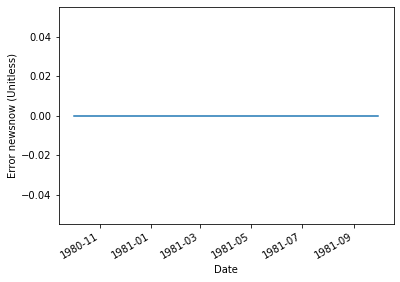

In [40]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Date")
plt.ylabel("Error newsnow (Unitless)")

Text(0, 0.5, 'pptmix (Unitless)')

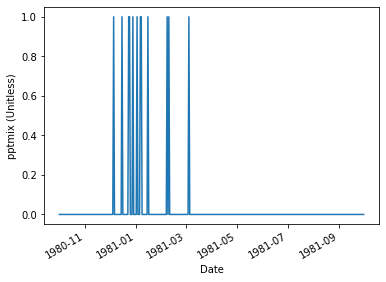

In [41]:
plt.plot(dates, pptmix)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Date")
plt.ylabel("pptmix (Unitless)")

Text(0, 0.5, 'pptmix (Unitless)')

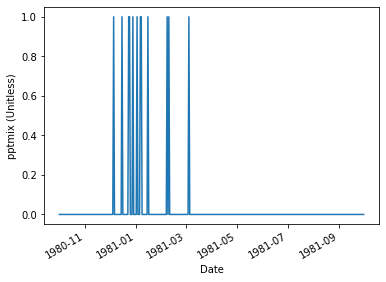

In [42]:
plt.plot(dates, synced_vals["pptmix"].values)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Date")
plt.ylabel("pptmix (Unitless)")

In [ ]:
err = synced_vals["pptmix"].values - pptmix

Text(0, 0.5, 'Error pptmix (Unitless)')

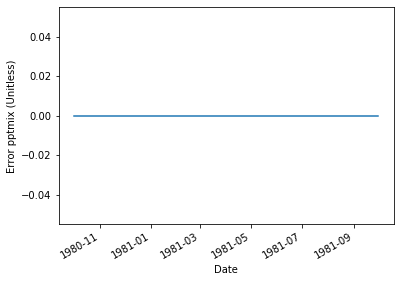

In [43]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Date")
plt.ylabel("Error pptmix (Unitless)")